# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display     import HTML
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [3]:
df_raw = pd.read_csv('../data/CC GENERAL.csv')

## 0.3 Data Dictionary

- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases 
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.90,0.82,95.40,0.00,95.40,0.00,0.17,0.00,0.08,0.00,0,2,1000.00,201.80,139.51,0.00,12
1,C10002,3202.47,0.91,0.00,0.00,0.00,6442.95,0.00,0.00,0.00,0.25,4,0,7000.00,4103.03,1072.34,0.22,12
2,C10003,2495.15,1.00,773.17,773.17,0.00,0.00,1.00,1.00,0.00,0.00,0,12,7500.00,622.07,627.28,0.00,12
3,C10004,1666.67,0.64,1499.00,1499.00,0.00,205.79,0.08,0.08,0.00,0.08,1,1,7500.00,0.00,NaN,0.00,12
4,C10005,817.71,1.00,16.00,16.00,0.00,0.00,0.08,0.08,0.00,0.00,0,1,1200.00,678.33,244.79,0.00,12


## 1.1 Rename Columns

In [6]:
df1.columns = df1.columns.str.lower()

## 1.2 Data Dimensions

In [7]:
df1.shape

(8950, 18)

O Dataset possui 8950 linhas e 18 colunas

## 1.3 Data Types

In [8]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4 Check Na

In [9]:
df1.isna().sum()*100/len(df1)

cust_id                            0.00
balance                            0.00
balance_frequency                  0.00
purchases                          0.00
oneoff_purchases                   0.00
installments_purchases             0.00
cash_advance                       0.00
purchases_frequency                0.00
oneoff_purchases_frequency         0.00
purchases_installments_frequency   0.00
cash_advance_frequency             0.00
cash_advance_trx                   0.00
purchases_trx                      0.00
credit_limit                       0.01
payments                           0.00
minimum_payments                   3.50
prc_full_payment                   0.00
tenure                             0.00
dtype: float64

## 1.5 Replace Na

In [10]:
df1 = df1.dropna()

## 1.6 Change Data Types

No momento nenhuma mudança será feita

## 1.7 Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.7.1 Numerical Attributes

In [12]:
# Central tendecy - mean, median
# Dispersion - std, min, max, skew, kurtosis
skew = num_attributes.skew()
kurtosis = num_attributes.kurtosis()

In [13]:
metrics = pd.DataFrame(num_attributes.describe().drop(['count']).T)
metrics = pd.concat([metrics, skew, kurtosis], axis=1).reset_index()
metrics.columns = ['Attributes','Mean','STD','Min','25%','Median','75%','Max','Skew','Kurtosis']

quartis = num_attributes.apply(lambda x: np.percentile(x, q=[10,25,50,75,95,99])).T.reset_index()
quartis.columns = ['Attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

metrics = pd.merge(metrics, quartis, how='inner', on='Attributes')
metrics

,Attributes,Mean,STD,Min,25%,Median,75%,Max,Skew,Kurtosis,P10,P25,P50,P75,P95,P99
0,balance,1601.22,2095.57,0.00,148.10,916.86,2105.20,19043.14,2.37,7.55,29.09,148.10,916.86,2105.20,5936.64,9369.55
1,balance_frequency,0.90,0.21,0.00,0.91,1.00,1.00,1.00,-2.08,3.37,0.55,0.91,1.00,1.00,1.00,1.00
2,purchases,1025.43,2167.11,0.00,43.37,375.40,1145.98,49039.57,8.06,108.68,0.00,43.37,375.40,1145.98,4060.09,9127.09
3,oneoff_purchases,604.90,1684.31,0.00,0.00,45.00,599.10,40761.25,9.94,160.12,0.00,0.00,45.00,599.10,2728.37,6783.90
4,installments_purchases,420.84,917.25,0.00,0.00,94.78,484.15,22500.00,7.22,94.19,0.00,0.00,94.78,484.15,1800.00,3916.48
5,cash_advance,994.18,2121.46,0.00,0.00,0.00,1132.39,47137.21,5.14,52.14,0.00,0.00,0.00,1132.39,4721.42,9681.63
6,purchases_frequency,0.50,0.40,0.00,0.08,0.50,0.92,1.00,0.03,-1.64,0.00,0.08,0.50,0.92,1.00,1.00
7,oneoff_purchases_frequency,0.21,0.30,0.00,0.00,0.08,0.33,1.00,1.50,1.06,0.00,0.00,0.08,0.33,1.00,1.00
8,purchases_installments_frequency,0.37,0.40,0.00,0.00,0.17,0.75,1.00,0.49,-1.42,0.00,0.00,0.17,0.75,1.00,1.00
9,cash_advance_frequency,0.14,0.20,0.00,0.00,0.00,0.25,1.50,1.80,3.18,0.00,0.00,0.00,0.25,0.58,0.83


### 1.7.2 Categorical Attributes

Não há variaveis categoricas para serem analisadas

# 2.0 Feature Engineering

### Columns Meaning

Balance ( Saldo ): Fatural atual - limite do cartão. O quanto falta de limite disponível para compra.
Possiveis Outliers

Balance Frequency: Frequência de uso do cartão ( usabilidade )

Purchases: O valor gasto no cartão acumulado dos últimos 6 meses ( a soma de todos os valores quando a pessoa passou o cartão na máquina de cartão )

Purchases On-Off: A soma de todas as compras pagas 1x no cartão, nos últimos 6 meses.
( Categoria )

Installmente Purchases: A soma de todas as compras pagas em mais de 1x no cartão, nos últimos 6 meses.
( Categoria )

Cash Advance: Valor do saque do limite do cartão de crédito, acumulado dos últimos 6 meses.
Um adiantamento em dinheiro é basicamente um empréstimo de curto prazo oferecido pelo emissor do 
cartão de crédito . Quando você pega um adiantamento em dinheiro, está tomando dinheiro emprestado 
contra a linha de crédito do seu cartão.

Purchases Frequency: Um valor de 0 a 1 que identifica a frequência de compra do cliente

Cash Advance Frequency: A frequência com que o cliente faz retiradas de dinheiro do seu cartão de crédito.

Cash Advance TRX: A quantidade de saques da conta do cartão de crédito

Purchases TRX: A quantidade de compras realizadas no cartão de crédito.

Credit Limit: O limite do cartão de crédito.

Payments: O valor pago além do mínimo da fatura ( não necessariamente a fatura toda )

Minimum Payments: O valor mínimo pago da fatura

Por exemplo:
Fatura total ( Payments ): 3000 
Pagamento mínimo ( mínimum payments ): 2000 
Pagamento efetivo de R$2.500

Payment = 500 
Minimum payments = 2000
Pagamento efeito = Payments + Minimum Payments

Tenure: O tempo de posse do cartão em meses ( O tempo em que a pessoa é cliente do banco )

In [14]:
df2 = df1.copy()

## 2.1 Feature Creation

In [13]:
# pagamento a vista ou não
df2['one_payment'] = df2['oneoff_purchases'].apply(lambda x: 0 if x==0 else 1)

# gasto medio por transação de compra
df2['avg_ticket_purchases'] = df2['purchases']/df2['purchases_trx']

# gasto médio por transação de compra totais
df2['avg_ticket_expanses'] = (df2['purchases']/df2['cash_advance'])/(df2['purchases_trx'] + df2['cash_advance_trx'])

# soma das despesas / soma de pagamentos
df2['debt_rate'] = (df2['purchases']/df2['cash_advance'])/(df2['payments'] + df2['minimum_payments'])

# percentual de uso do limite do cartão
df2['credit_limit_rate'] = (df2['purchases'] + df2['cash_advance']) / 6*(df2['credit_limit'])

# 3.0 Variable Filtering

In [14]:
df3 = df2.copy()

In [15]:
df3 = df3.drop_duplicates(subset=['cust_id'])

# 4.0 EDA

In [16]:
df4 = df3.copy()

# 5.0 Data Preparation

In [17]:
df5 = df4.copy()

## 5.1 Rescaling

In [19]:
mms = MinMaxScaler()

In [20]:
df5 = df5.drop('cust_id', axis=1)

In [1]:
cols = ['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure']

In [21]:
df5[cols] = mms.fit_transform(df5[cols].values)

# 6.0 Feature Selection

In [23]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [25]:
X = df6.copy()

In [40]:
clusters = [2,3,4,5,6,7,8,9,10]

## 7.1 Calinski Harabasz Index

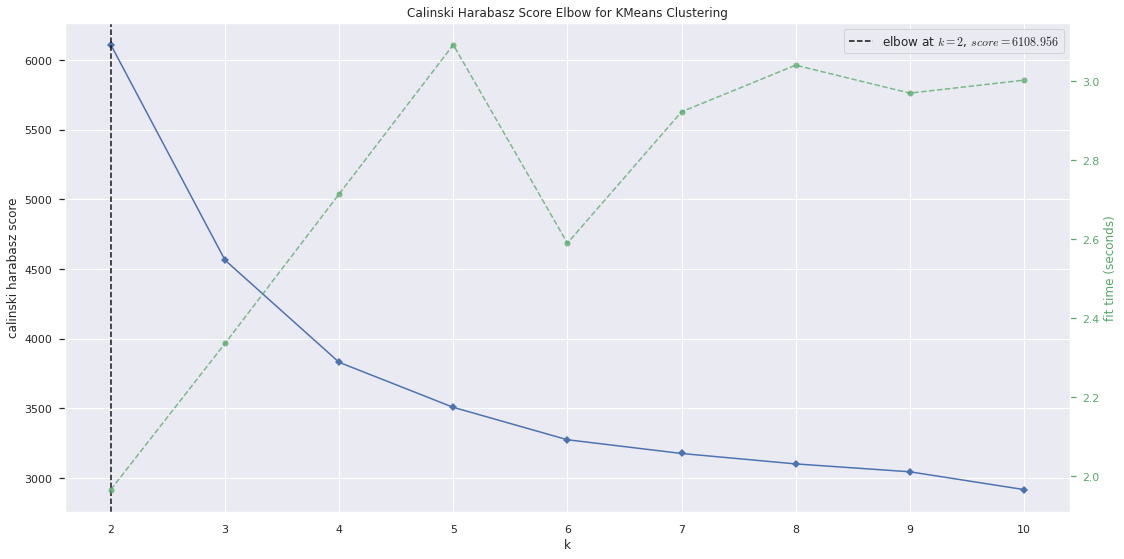

In [41]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='calinski_harabasz', timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

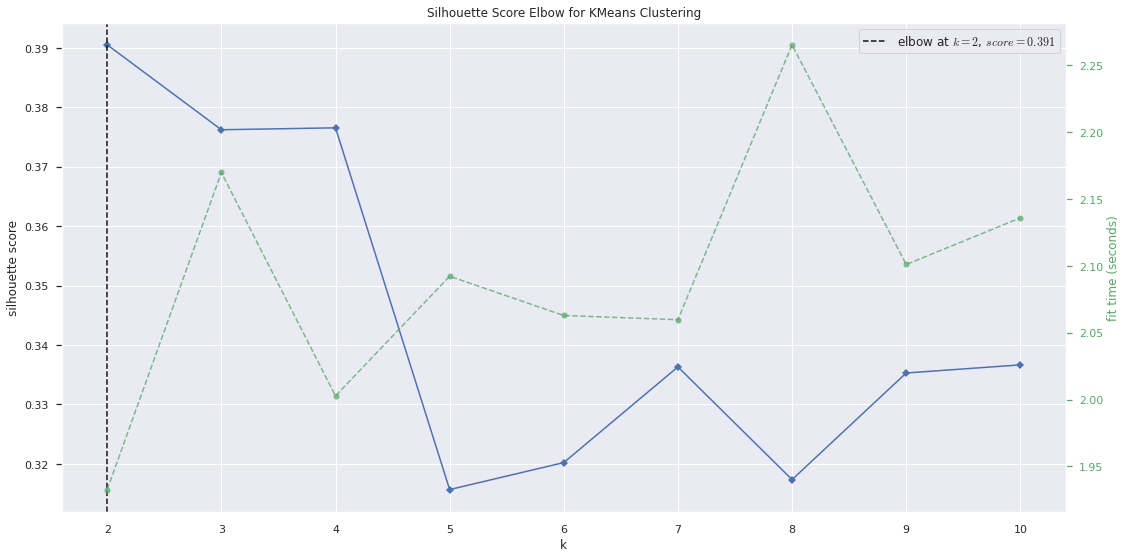

In [29]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show();

### 7.2.1 Silhouette Analysis

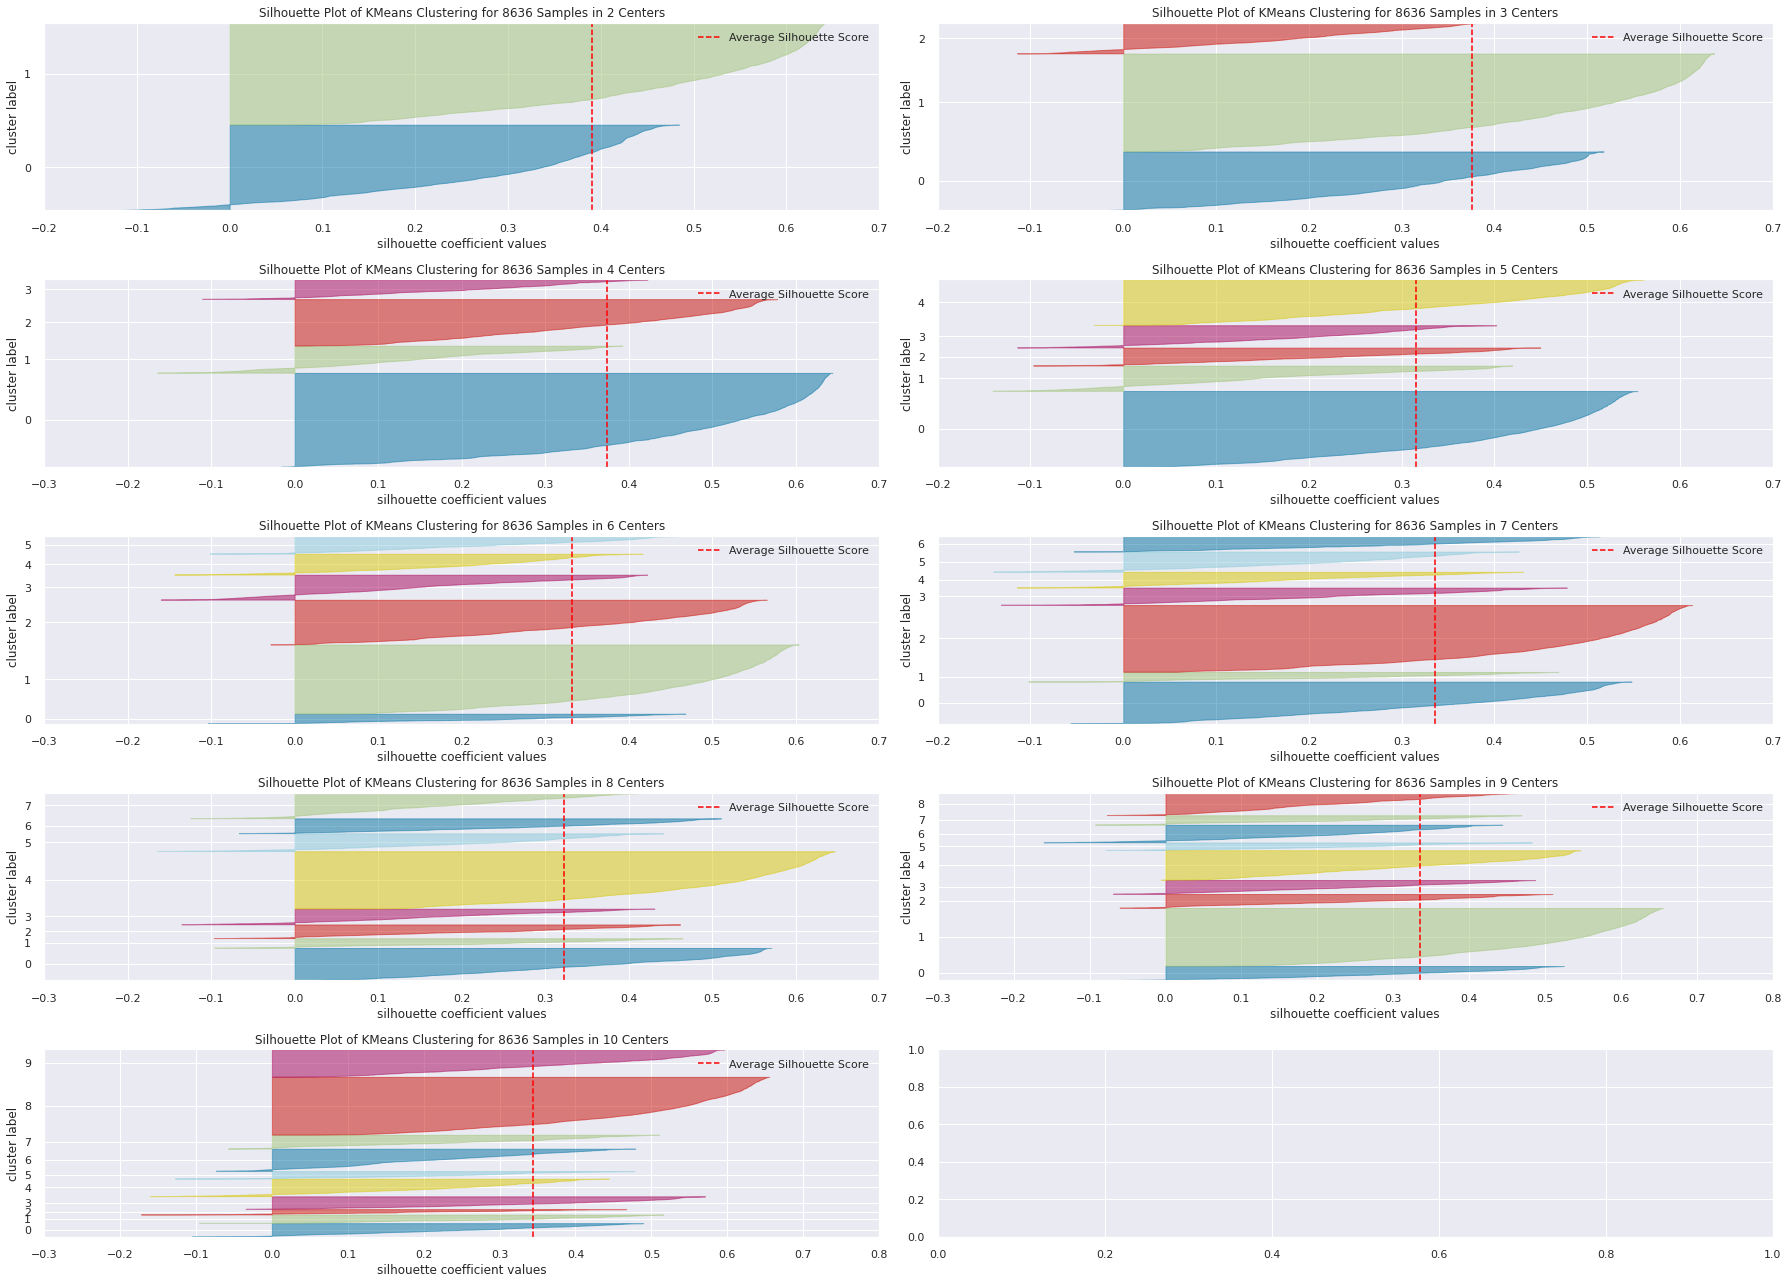

In [49]:
fig,ax = plt.subplots(5,2, figsize=(25,18))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()
    
plt.tight_layout()

## 7.3 Davies-Bouldin Index

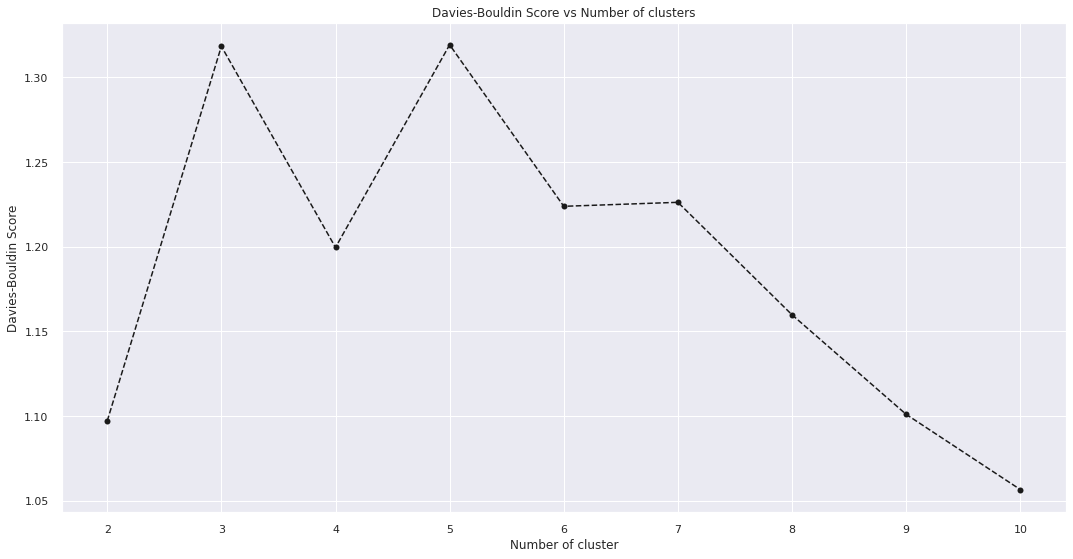

In [31]:
score = []

for k in clusters:
    # model definiton
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    
    # model training
    kmeans.fit(X)
    
    # clustering
    labels =kmeans.labels_
    
    # validation
    score.append(davies_bouldin_score(X, labels))
    
# plot wss
plt.plot(clusters, score, linestyle='--', marker='o', color='k')
plt.xlabel('Number of cluster');
plt.ylabel('Davies-Bouldin Score');
plt.title('Davies-Bouldin Score vs Number of clusters');

# 8.0 Model Training

## 8.1 KMeans

In [57]:
# model definition
k = 10
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model traiing
kmeans.fit(X)

# clustering
labels =kmeans.labels_

## 8.2 Cluster Validation

In [58]:
## Calinski Harabasz Score
print('Calinski Harabasz Score Value: {}'.format(calinski_harabasz_score(X, labels)))

## SS (Silhouette Score)
print('SS value: {}'.format(silhouette_score(X, labels, metric='euclidean')))

## Davies-Bouldin Score
print('Davies Bouldin Score Value: {}'.format(davies_bouldin_score(X, labels)))

Calinski Harabasz Score Value: 3011.429888816202
SS value: 0.33666641100114914
Davies Bouldin Score Value: 1.0450748604766864


# 9.0 Cluster Analysis

## 9.1 Cluster Profile